# 1.Data Exploration and Analysis

(1) Explore three Three Census Data each from 1995, 2005 and 2015. See the trending of total number of trees in NYC.

Text(0, 0.5, 'Total Number Of Trees in NYC')

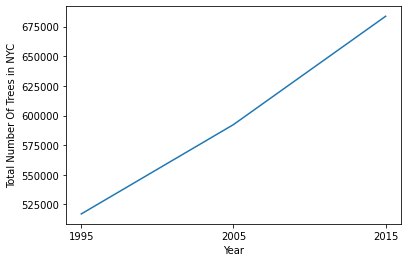

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
trees_2015 = pd.read_csv('2015_Street_Tree_Census_Tree_Data.csv',low_memory=False)
trees_2005 = pd.read_csv('NewYorkCity_StreetTreeCensus_2005.csv',low_memory=False)
trees_1995 = pd.read_csv('1995_Street_Tree_Census.csv', low_memory=False)
plt.plot(['1995', '2005', '2015'], [trees_1995.shape[0],trees_2005.shape[0], trees_2015.shape[0]])
plt.xlabel("Year")
plt.ylabel("Total Number Of Trees in NYC")

(2) How about total species of trees in 1995, 2005 and 2015?

Text(0, 0.5, 'Total Species Of Trees in NYC')

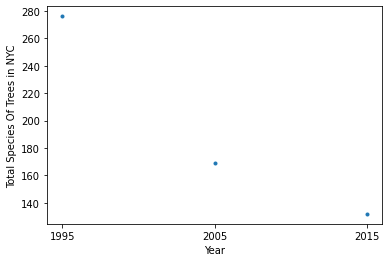

In [167]:
species_2015 = trees_2015['spc_common'].nunique()
species_2005 = trees_2005['spc_common'].nunique()
species_1995 = trees_1995['Spc_Common'].nunique()
plt.plot(['1995', '2005', '2015'], [species_1995,species_2005, species_2015],'.')
plt.xlabel("Year")
plt.ylabel("Total Species Of Trees in NYC")

# 2. Explore factors that may affect health status for trees

(1) Trees health Status in different borough in 2015, which borough has the best health status?

In [168]:
def aggregate_health(trees_2015_borough):
    borough_health = trees_2015_borough.groupby('health').size()
    borough_health['health_ratio'] = (borough_health['Good'] + borough_health['Fair']) / borough_health['Poor']
    return borough_health

trees_2015_borough = trees_2015.groupby('borough').apply(aggregate_health).sort_values(by='health_ratio',ascending=False).reset_index()
print(trees_2015_borough)

health        borough     Fair      Good    Poor  health_ratio
0            Brooklyn  25073.0  138212.0  6459.0     25.280229
1               Bronx  10887.0   66603.0  3095.0     25.037157
2              Queens  34549.0  194008.0  9417.0     24.270681
3       Staten Island  14535.0   82669.0  4238.0     22.936291
4           Manhattan  11460.0   47358.0  3609.0     16.297589


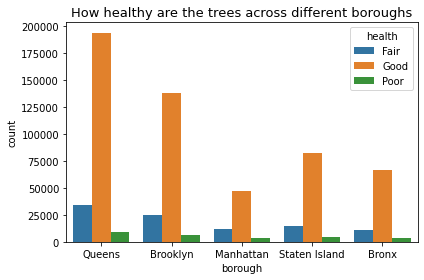

In [169]:
h = sns.countplot(x = 'borough', data=trees_2015, hue='health')
plt.title('How healthy are the trees across different boroughs', size=13)
plt.tight_layout()
plt.show()

(2) Will the bad sidewalk affect trees' health status? - By conducting chi-square test.

In [140]:
from scipy.stats import chi2_contingency
healthy_good_sidewalk = unhealthy_good_sidewalk = healthy_bad_sidewalk = unhealthy_bad_sidewalk = 0
for index, row in trees_2015.iterrows():    
    if row['health'] != 'Poor' and row['sidewalk'] != 'Damage':
        healthy_good_sidewalk += 1
    if row['health'] == 'Poor' and row['sidewalk'] != 'Damage':
        unhealthy_good_sidewalk += 1
    if row['health'] != 'Poor' and row['sidewalk'] == 'Damage':
        healthy_bad_sidewalk += 1
    if row['health'] == 'Poor' and row['sidewalk'] == 'Damage':
        unhealthy_bad_sidewalk += 1
print(healthy_good_sidewalk, unhealthy_good_sidewalk, healthy_bad_sidewalk, unhealthy_bad_sidewalk)
healthy_total = healthy_good_sidewalk + healthy_bad_sidewalk
unhealthy_total = unhealthy_good_sidewalk + unhealthy_bad_sidewalk
good_sidewalk = healthy_good_sidewalk + unhealthy_good_sidewalk
bad_sidewalk = healthy_bad_sidewalk + unhealthy_bad_sidewalk
grand_total = healthy_total + unhealthy_total
contingency_table = [[healthy_total*good_sidewalk/grand_total,healthy_total*bad_sidewalk/grand_total],
                     [unhealthy_total*good_sidewalk/grand_total,unhealthy_total*bad_sidewalk/grand_total]] #could use crosstab to auto create this table
stat, p, dof, expected = chi2_contingency(contingency_table)
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))  
if p <= alpha:
    print('Variables are associated (reject H0)')
else:
    print('Variables are not associated(fail to reject H0)')

476381 20213 180589 6605
significance=0.050, p=1.000
Variables are not associated(fail to reject H0)


(3) Import 2015 Air Quality Data, does the trees health status relate to any air quality indicator? (Using mean PM2.5 value as an example indicator here)

In [170]:
AQI_2015 = pd.read_csv('annual_conc_by_monitor_2015.csv', low_memory=False)
AQI_2015_NYC = AQI_2015[AQI_2015['City Name'] == 'New York']
AQI_2015_NYC = AQI_2015_NYC[AQI_2015_NYC['Parameter Name'] == 'PM2.5 - Local Conditions']
AQI_borough = AQI_2015_NYC.groupby('County Name')['Arithmetic Mean'].mean().to_frame(name = 'Mean PM2.5').reset_index()
AQI_borough = AQI_borough.replace(to_replace ='New York', value ='Manhattan') 
AQI_borough = AQI_borough.replace(to_replace ='Kings', value = 'Brooklyn')
AQI_borough = AQI_borough.replace(to_replace = 'Richmond', value ='Staten Island')
AQI_borough['County Name'] = AQI_borough['County Name'].str.strip()
trees_2015_borough['borough'] = trees_2015_borough['borough'].str.strip()
combined_2015 = AQI_borough.set_index('County Name').join(trees_2015_borough.set_index('borough'), how = 'inner')
print(combined_2015)
   

               Mean PM2.5     Fair      Good    Poor  health_ratio
Bronx            8.740817  10887.0   66603.0  3095.0     25.037157
Brooklyn         9.194690  25073.0  138212.0  6459.0     25.280229
Manhattan        9.858955  11460.0   47358.0  3609.0     16.297589
Queens           7.850824  34549.0  194008.0  9417.0     24.270681
Staten Island    8.612821  14535.0   82669.0  4238.0     22.936291


We will look at the Correlation Plot, do a Correlation Test and calculate the correlation coefficient.

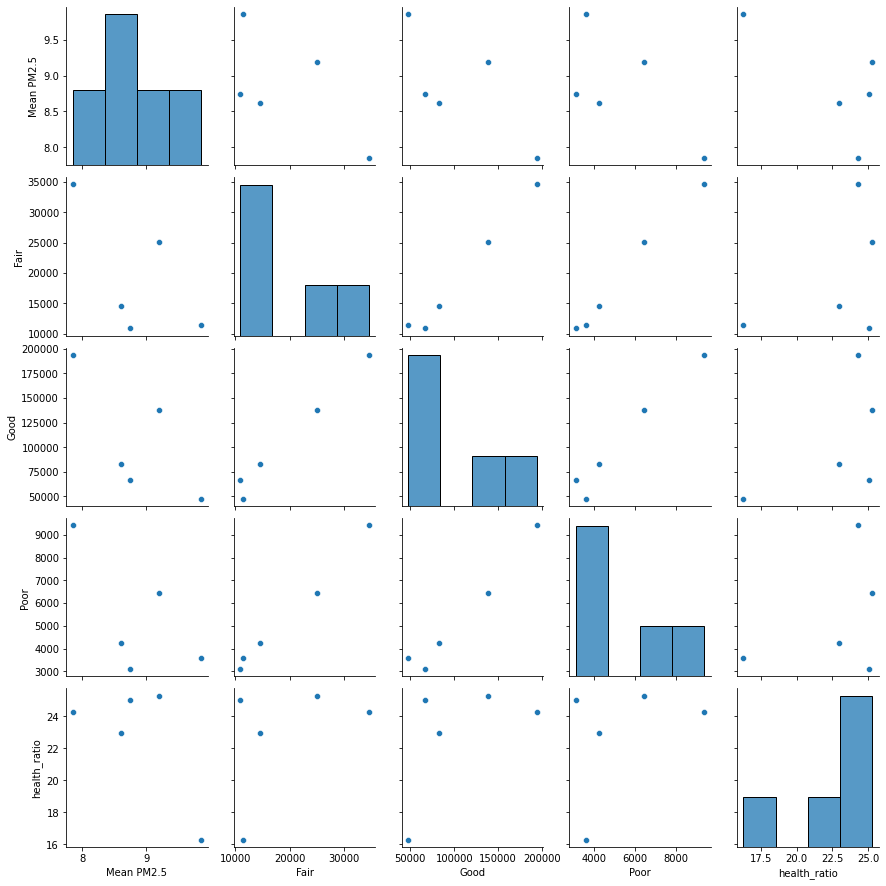

In [164]:
sns.pairplot(combined_2015, kind = 'scatter')
plt.show()

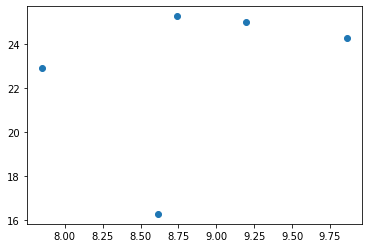

In [158]:
plt.scatter(combined_2015['Mean PM2.5'], combined_2015['health_ratio'])
plt.show()

In [172]:
from scipy.stats import linregress
linregress(combined_2015['Mean PM2.5'], combined_2015['health_ratio'])

LinregressResult(slope=-3.381946134082324, intercept=52.70009554556884, rvalue=-0.6731583545098264, pvalue=0.21296545419201948, stderr=2.14499377365775)

Since the p-value of 0.2814 is greater than 0.05, we fail to reject the null hypothesis that the relationship between the trees health status and AQI PM2.5 is not significant.